In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import typhon.plots
from netCDF4 import Dataset
from typhon.utils import image2mpeg


plt.style.use(typhon.plots.styles('typhon'))

fascod_seasons = [
    'tropical',
    'midlatitude-summer',
    'midlatitude-winter',
    'subarctic-summer',
    'subarctic-winter',
]

# Simple timeseries

In [ ]:
vmin = 180
vmax = 340

import glob


for season in fascod_seasons:
    data = Dataset('results/{}.nc'.format(season))

    fig, ax = plt.subplots()
    sm = ax.pcolormesh(
        data.variables['time'][:] / 24,
        data.variables['plev'][:],
        data.variables['T'][:].T,
        cmap=plt.get_cmap('temperature', 20),
        rasterized=True,
        vmin=vmin,
        vmax=vmax,
    )
    fig.colorbar(sm, label='Temperature [K]')
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.set_ylim(1100e2, 0.1e2)
    ax.yaxis.set_major_formatter(typhon.plots.fmt_hectopascal)
    ax.set_title('FASCOD {}'.format(season))
    ax.set_xlabel('Days')
    ax.set_ylabel('Pressure [hPa]')
    fig.savefig('plots/{}.pdf'.format(season))

# Timeseries animation

In [ ]:
for season in fascod_seasons:
    data = Dataset('results/{}.nc'.format(season))
    time = data.variables['time'][:] / 24
    p = data.variables['plev'][:]
    T = data.variables['T'][:].T
    
    for t in range(1, time.size, 5):
        fig, [ax2, ax1] = plt.subplots(1, 2, sharey=True, figsize=(16, 8), gridspec_kw={'width_ratios':[1, 3]})
        sm = ax1.pcolormesh(
            time[0:t+1],
            p,
            T[:, 0:t+1],
            cmap=plt.get_cmap('temperature', 10),
            rasterized=True,
            vmin=vmin,
            vmax=vmax,
        )
        fig.colorbar(sm, label='Temperature [K]', ax=ax1)
        sm = ax1.pcolormesh(
            time[t:],
            p,
            T[:, t:],
            cmap=plt.get_cmap('Greys_r', 10),
            rasterized=True,
            vmin=vmin,
            vmax=vmax,
        )
        ax1.axvline(time[t])  # vertical line to highlight current timestep.
        ax1.invert_yaxis()
        ax1.set_ylim(1100e2, 10)
        ax1.yaxis.set_major_formatter(typhon.plots.fmt_hectopascal)
        fig.suptitle('FASCOD {}'.format(season))
        ax1.set_xlabel('Days')

        # temperature sounding
        typhon.plots.profile_p_log(p, T[:, t], ax=ax2)
        ax2.set_ylim(1100e2, 10)
        ax2.set_xlim(vmin, vmax)
        ax2.set_xlabel('Temperature [K]')
        fig.savefig('plots/animation/{}_{:04d}.png'.format(season, t), dpi=300)
        plt.close(fig)
    
    image2mpeg(
        glob='plots/animation/{}_*.png'.format(season),
        outfile='plots/animation/{}.mp4'.format(season),
    )

# Convective adjustment

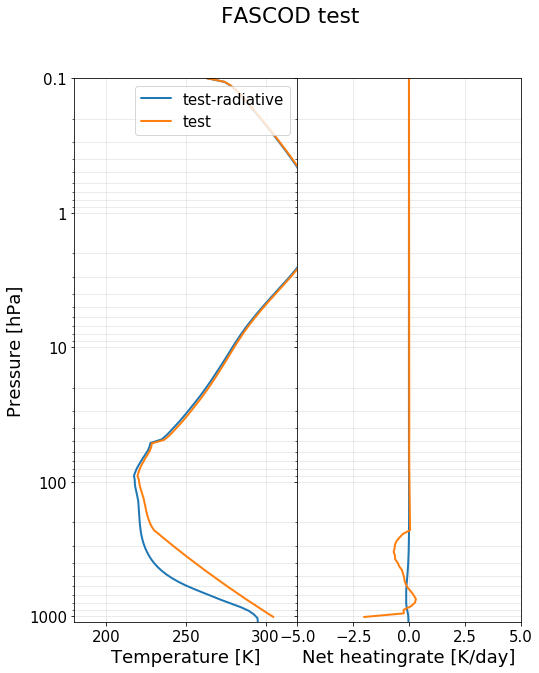

In [4]:
scenarios = ['test-radiative', 'test']
data = {s: Dataset('results/{}.nc'.format(s)) for s in scenarios}

# Number of timesteps for each scenario
timesteps = {k: d.variables['time'].shape[0] for k, d in data.items()}

for t in range(0, max(timesteps.values()), 5):
    fig, [ax, ax2] = plt.subplots(ncols=2, sharey=True, figsize=(8, 10))
    fig.subplots_adjust(wspace=0)
    for scenario in scenarios:
        # Clip timestep to maximum for scenraio, preventing out of index errors.
        ti = np.clip(t, a_min=0, a_max=timesteps[scenario] - 1)
        
        typhon.plots.profile_p_log(
            data[scenario].variables['plev'][:],
            data[scenario].variables['T'][ti, :],
            label=scenario,
            ax=ax,
        )
        ax.set_xlim(180, 320)
        ax.set_ylim(1100e2, 0.1e2)
        ax.grid('on', which='both', linestyle='solid', alpha=0.3)
        ax.legend(loc='upper right')
        fig.suptitle('FASCOD {}'.format(scenario))
        ax.set_xlabel('Temperature [K]')
        ax.set_ylabel('Pressure [hPa]')
        
        typhon.plots.profile_p_log(
            data[scenario].variables['plev'][:],
            data[scenario].variables['net_htngrt'][ti, :],
            label=scenario,
            ax=ax2,
        )
        ax2.set_xlim(-5, 5)
        ax2.grid('on', which='both', linestyle='solid', alpha=0.3)
        # ax.legend(loc='upper right')
        ax2.set_xlabel('Net heatingrate [K/day]')
    fig.savefig('plots/convection/iter_{:04d}.png'.format(t))
    plt.close(fig)
    
image2mpeg(
    glob='plots/convection/iter_*.png',
    outfile='plots/convection/convection.mp4',
)